In [1]:

import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import weightedstats as ws


# consider using this for weighted stats: http://www.ccgalberta.com/pygeostat/welcome.html



## Functions and tools used in the analysis

In [2]:
def weighted_mean(var, wts):
    """Calculates the weighted mean"""
    return np.average(var, weights=wts)

def weighted_median_series(val, weight):
    """Calculates the weighted median
    ArithmeticError
    If the sum of the weights is zero, or if the weights are not positive.
    """
    try:
        df = pd.DataFrame({"val": val, "weight": weight})
        df_sorted = df.sort_values("val")
        cumsum = df_sorted["weight"].cumsum()
        cutoff = df_sorted["weight"].sum() / 2.
        result = df_sorted[cumsum >= cutoff]["val"].iloc[0]
        # return just the value
    except:
        result = np.nan
    return result

def weighted_median(df, val_column, weight_column):
    """Calculates the weighted median
    ArithmeticError
    If the sum of the weights is zero, or if the weights are not positive.
    """
    df_sorted = df.sort_values(val_column)
    cumsum = df_sorted[weight_column].cumsum()
    cutoff = df_sorted[weight_column].sum() / 2.
    return df_sorted[cumsum >= cutoff][val_column].iloc[0]

def run_weighted_median_on_grouped_df(df, groupby_column, value_column, weight_column):
    """Calculate the weighted median of a dataframe grouped by a column.
    Args:
        df (pandas.DataFrame): DataFrame to calculate weighted median on.
        groupby_column (str): Column to group by.
        value_column (str): Column to calculate weighted median on.
        weight_column (str): Column to use as weight.
    Returns:
        pandas.DataFrame: DataFrame with weighted median for each group.
    """
    # initialize empty list
    d = []
    # loop through each group
    for i in df[groupby_column].unique():
        df_group = df[df[groupby_column] == i]
        # if rows in dataframe are more than 1, calculate weighted median
        if len(df_group) > 1:
            median = weighted_median(df_group, value_column, weight_column)
        else:
            median = df_group[value_column].values[0]
        d.append(
            {
                groupby_column: i,
                "median": median,
            }
        )
    return pd.DataFrame(d)


def load_data(data_file: str) -> pd.DataFrame:
    '''
    Load data from /data directory
    '''
    PATH = pathlib.Path().resolve()
    DATA_PATH = PATH.joinpath("../data").resolve()
    return pd.read_csv(DATA_PATH.joinpath(data_file))



## Import Data from CSVs.
CSVs created in previous script, which did the cycling mobility on a per country basis

In [3]:


df_zones_input= load_data("GIS/export_urb.csv")
# import df_input and set index as alpha 3 
df_input = load_data("country_data_with_cycling_distance.csv")

## manual adjustment of some columns
df_zones_input["dtw_1"] = df_zones_input["dtw_1"] / 1000 # turn to kms
df_zones_input["max distance walking"] = 3.0 # temp, set max distance reachbale for all countriesl, will change to be bespoke soon
df_input["max distance cycling"] = 8 * df_input["trip_velocity_mean"] # temp, set max distance reachbale for all countriesl, will change to be bespoke soon

# Manage Urban / Rural Data
Use the GHS_SMOD_E2020_GLOBE_R2023A_54009_1000_V1_0 dataset.
from here: https://ghsl.jrc.ec.europa.eu/download.php?ds=smod

In [28]:

# create new binary column for urban / rural. Rural is below 15, Urban above 15
df_zones_input["urban_rural"] = np.where(df_zones_input["URBAN_1"] > 15, 1, 0)

df_zones_input["urban_rural"].value_counts()


0    2220541
1      42618
Name: urban_rural, dtype: int64

In [34]:
df_zones_input.columns

Index(['fid', 'id', 'left', 'top', 'right', 'bottom', 'Value', 'ISOCODE',
       'UNSDCODE', 'NAME0', 'CIESINCODE', 'DATATYPE', 'DATACODE', 'DATAYEAR',
       'DATALEVEL', 'SEXLEVEL', 'AGELEVEL', 'GRSTART', 'GREND', 'GRLEVEL',
       'LASTCENSUS', 'MEANUNITKM', 'dtw_1', 'pop_count_15_1', 'AdjPop',
       'AdjPopFloat', 'vrm1', 'grip_total', 'slope_1', 'grip_1_1', 'grip_2_1',
       'grip_3_1', 'grip_4_1', 'grip_5_1', 'tri_med_1', 'tri_max_1', 'URBAN_1',
       'max distance walking', 'urban_rural'],
      dtype='object')

0.0

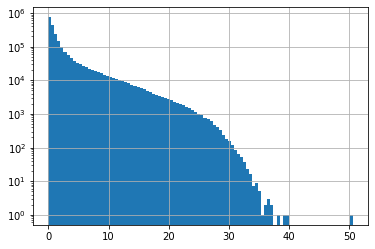

In [37]:
# histogram of slope_1 log scale
df_zones_input["slope_1"].hist(bins=100, log=True)

# find all zones with greater than 20 slope, calculate the population in these zones. DO SLOPE NEXT

## Merge the dataframes
Do some manual adjustments to populations

In [4]:

# this analysis loses some data as the overlap between the rasters is not perfect. To reduce this error, use the 30 arc second data. Too much heavy lifting for my computer to do this at the moment.

#merge df_input and df_zones on ISO_CC. This assigns all the country data to each zone.
# join inner will remove some of the data that is not in both datasets
df_zones = df_zones_input.merge(df_input, left_on="ISOCODE", right_on="alpha3", how="inner")

# these are the columns
# alpha3,Unnamed: 0,Entity,Population,YearPBO,PBO,Terrain Ruggedness,Urban %,Urban Agg %,RoadQuality,Km,Urb %,Average household size (number of members),National At Least Basic,National Limit (more than 30 mins),National Unimproved,National Surface Water,Nat Accesible On Premises,Nat Piped,Nat NonPiped,No. HPs,Year of HP estimate,2015 (C),No. HPs in 2015,Non-functional HPs,Functional HPS,Risk Score,alpha2,region,subregion,borders,Mean BMI (male),Mean BMI (female),Mean male height (cm),Mean female height (cm),women weight,men weight,percent_insufficient_activity,Average Weight,power,Crr,trip_velocity_mean,unloaded_velocity_mean,loaded_velocity_mean,velocitykgs,water_ration_kms

#adjust population to account for 9 values per raster point (2.5 to 5 arc min resoltuions. 9 values per point)
df_zones["AdjPopFloat"] = df_zones["pop_count_15_1"] / 9 

# # convert population density to percent of national population on a per country basis, grouped by ISO_CC
df_zones["pop_density_perc"] = df_zones.groupby("ISOCODE")["AdjPopFloat"].apply(lambda x: x / x.sum())

# multiply population density by population on a per country basis
df_zones["pop_zone"] = df_zones["pop_density_perc"] * df_zones["Population"]



In [5]:
# sum the population in each zone
df_zones["country_pop_raw"] = df_zones.groupby("ISOCODE")["pop_zone"].transform("sum")
df_zones["country_pop_ratio"] = df_zones.groupby("ISOCODE")["AdjPopFloat"].transform("sum")


# Below is temporary Stuff!

<AxesSubplot:>

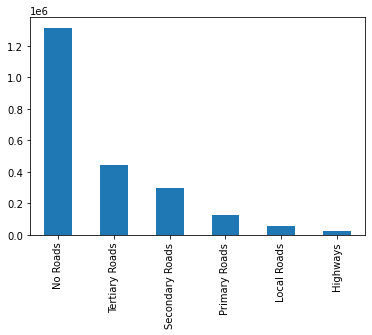

In [6]:
# sort by trip velocity mean, then find the top 10 fastest countries
# ["trip_velocity_mean"]
# df_input["kgs_carried"]= df_input["velocitykgs"] /df_input["trip_velocity_mean"] 
# df_input["Average household size (number of members)"].describe()
# df_input.sort_values(by=["kgs_carried"], ascending=False).head(10)



df_zones.columns
# output:
# Index(['fid', 'id', 'left', 'top', 'right', 'bottom', 'Value', 'ISOCODE',
#        'UNSDCODE', 'NAME0', 'CIESINCODE', 'DATATYPE', 'DATACODE', 'DATAYEAR',
#        'DATALEVEL', 'SEXLEVEL', 'AGELEVEL', 'GRSTART', 'GREND', 'GRLEVEL',
#        'LASTCENSUS', 'MEANUNITKM', 'dtw_1', 'pop_count_15_1', 'AdjPop',
#        'AdjPopFloat', 'vrm1', 'grip_1', 'slope_1', 'grip_11', 'grip_21',
#        'grip_3_1', 'grip_4_1', 'grip_5_1', 'grip_total_1',
#        'max distance walking'],
#       dtype='object')


# input columns
# Index(['alpha3', 'Unnamed: 0', 'Entity', 'Population', 'YearPBO', 'PBO',
#        'Terrain Ruggedness', 'Urban %', 'Urban Agg %', 'RoadQuality', 'Km',
#        'Urb %', 'Average household size (number of members)',
#        'National At Least Basic', 'National Limit (more than 30 mins)',
#        'National Unimproved', 'National Surface Water',
#        'Nat Accesible On Premises', 'Nat Piped', 'Nat NonPiped', 'No. HPs',
#        'Year of HP estimate', '2015 (C)', 'No. HPs in 2015',
#        'Non-functional HPs', 'Functional HPS', 'Risk Score', 'alpha2',
#        'region', 'subregion', 'borders', 'Mean BMI (male)',
#        'Mean BMI (female)', 'Mean male height (cm)', 'Mean female height (cm)',
#        'women weight', 'men weight', 'percent_insufficient_activity',
#        'Average Weight', 'power', 'Crr', 'trip_velocity_mean',
#        'unloaded_velocity_mean', 'loaded_velocity_mean', 'velocitykgs',
#        'water_ration_kms', 'max distance cycling'],
#       dtype='object')


# # any roads = 1, no roads = 0
# df_zones["any_road"] = df_zones["grip_total_1"].apply(
#     lambda x: 1 if x > 0 else 0
# )

# # find non zero values AdjPopFloat
# df_zones["any_pop"] = df_zones["AdjPopFloat"].apply(
#     lambda x: 1 if x > 0 else 0
# )

# # findcorrelation between any_road and any_pop
# df_zones[["any_road", "any_pop"]].corr()


# describe each of the following:
#'grip_11', 'grip_21', 'grip_3_1', 'grip_4_1', 'grip_5_1'
df_zones[["grip_1_1", "grip_2_1", "grip_3_1", "grip_4_1", "grip_5_1"]].describe()


def find_dominant_road(row):
    if row.sum() == 0:
        return 'No Roads'
    else:
        return row.idxmax()

df_zones['dominant_road_type'] = df_zones[["grip_1_1", "grip_2_1", "grip_3_1", "grip_4_1", "grip_5_1"]].apply(find_dominant_road, axis=1)

df_zones['dominant_road_type'] = df_zones['dominant_road_type'].replace({
    'grip_1_1': 'Highways',
    'grip_2_1': 'Primary Roads',
    'grip_3_1': 'Secondary Roads',
    'grip_4_1': 'Tertiary Roads',
    'grip_5_1': 'Local Roads'
})


# histogram of dominant road type
df_zones['dominant_road_type'].value_counts().plot(kind='bar')


# df_zones['dominant_road_type'].describe()
# # # look at vector roughenss
# df_zones["AdjPopFloat"].describe()

# # # plot the grip_total_1 column, log scale binning
# df_zones["AdjPopFloat"].plot.hist(bins=100, log=True)



# find the percentage of zones with roads


# # output the binned vector roughness to a table, save as a csv
# df_zones_input["vrm1"].value_counts(bins=100, sort=False).to_csv(
#     "../data/processed/roughness_bins.csv"
# )

# # create a fit for the vector roughness
# # Nominal Slope=a⋅log⁡(b⋅VRM+c)+d
# # use the scipy curve fit function to fit the data
# from scipy.optimize import curve_fit

# # define the function to fit
# def func(x, a, b, c, d):
#     return a * np.log(b * x + c) + d

# # define the x and y data
# xdata = df_zones_input["vrm1"].value_counts(bins=100, sort=False).index.mid
# ydata = df_zones_input["vrm1"].value_counts(bins=100, sort=False).values






In [21]:
# histogram 
print(df_zones.columns)

Index(['fid', 'id', 'left', 'top', 'right', 'bottom', 'Value', 'ISOCODE',
       'UNSDCODE', 'NAME0',
       ...
       'fraction_of_zone_with_cycling_access',
       'fraction_of_zone_with_walking_access',
       'population_piped_with_cycling_access',
       'population_piped_with_walking_access', 'population_piped_with_access',
       'zone_pop_with_water', 'zone_pop_without_water',
       'water_rations_per_bike', 'bikes_in_zone', 'water_rations_achievable'],
      dtype='object', length=105)


In [7]:
# df_zones['dominant_road_type'].value_counts().plot(kind='bar')

# histogram og househould
# df_zones['Average household size (number of members)'].hist(bins=100)

# export to csvdf_zones:
# df_zones.to_csv('../data/df_zones.csv')

# plot average household size in increasing order using plotly
# fig = px.line(df_input.sort_values(by='Average household size (number of members)'), x="Entity", y="Average household size (number of members)", color="subregion")
# # px.line(df_input.sort_values(by='Average household size (number of members)')['Average household size (number of members)'])
# # save plot
# fig.write_html("../data/average_household_size.html")


# create a new series with the 'inhabited vrm' values. THis uses any_pop, put over the top of the vrm values, 'vrm1'
# find non zero values AdjPopFloat
df_zones["any_pop"] = df_zones["AdjPopFloat"].apply(
    lambda x: 1 if x > 10 else 0
)


df_zones["any_pop"].describe()

# describe vrm filtered by any_pop =1
df_zones[df_zones["any_pop"] == 1]["slope_1"].describe()



count    1.481674e+06
mean     2.858239e+00
std      4.484592e+00
min      0.000000e+00
25%      3.763624e-01
50%      9.683968e-01
75%      2.984939e+00
max      5.051991e+01
Name: slope_1, dtype: float64

## The section below calculates the population per zone that can reach water

Consider putting in household size and bike sharing here

In [8]:
df_input.head()

,alpha3,Unnamed: 0,Entity,Population,YearPBO,PBO,Terrain Ruggedness,Urban %,Urban Agg %,RoadQuality,...,percent_insufficient_activity,Average Weight,power,Crr,trip_velocity_mean,unloaded_velocity_mean,loaded_velocity_mean,velocitykgs,water_ration_kms,max distance cycling
0,ABW,0,Aruba,107195.0,NaN,23.023333,46.2,43.696999,37.284118,3.833333,...,34.308333,77.214823,72.468719,0.017797,0.957795,1.086109,0.829482,58.742153,112.784934,7.662360
1,AFG,1,Afghanistan,39835428.0,2011.0,31.820000,251.8,26.025999,10.884323,4.575000,...,25.880000,60.111881,76.728516,0.014162,1.277013,1.462445,1.091581,77.868735,149.507972,10.216102
2,AGO,2,Angola,33933611.0,2008.0,8.700000,85.8,66.824997,25.437248,4.400000,...,26.825000,61.562906,76.250899,0.015020,1.231163,1.410087,1.052240,75.054177,144.104019,9.849307
3,AIA,3,Anguilla,15125.0,NaN,23.023333,1.3,63.807524,37.284118,3.833333,...,34.308333,77.214823,72.468719,0.017797,0.957795,1.086109,0.829482,58.742153,112.784934,7.662360
4,ALB,4,Albania,2872934.0,2008.0,21.400000,342.7,62.112000,29.633070,3.900000,...,37.700000,75.532649,70.754523,0.017470,0.957657,1.087464,0.827850,58.681329,112.668151,7.661257


In [9]:
# population with piped water
df_zones["zone_pop_piped"] = df_zones["pop_zone"]*df_zones["Nat Piped"]/100
# calculaye unpiped, this is not "un piped" from the dataset, but rather the population that does not have piped water
# unpiped from the dataset refers to ONLY inproved unpiped. So do 100 - piped to get the total unpiped (inlcuding unimproved water sources)
df_zones["zone_pop_unpiped"] = df_zones["pop_zone"]*(100-df_zones["Nat Piped"])/100


# is it possible to reach water with walking/cycling
df_zones["zone_cycling_okay"] = (df_zones["dtw_1"] < df_zones["max distance cycling"])*1 # multiply by 1 to force to binary not true/false
df_zones["zone_walking_okay"] = (df_zones["dtw_1"] < df_zones["max distance walking"])*1

# how many people can collect water in the zone
df_zones["fraction_of_zone_with_cycling_access"] = df_zones["zone_cycling_okay"]* (df_zones["PBO"])/100
df_zones["fraction_of_zone_with_walking_access"] = df_zones["zone_walking_okay"] * 1

#
df_zones["population_piped_with_cycling_access"] = df_zones["fraction_of_zone_with_cycling_access"] * df_zones["zone_pop_piped"]
df_zones["population_piped_with_walking_access"] = df_zones["fraction_of_zone_with_walking_access"] * df_zones["zone_pop_piped"]

# select the maximum between the two, if walkable, max will always be walking
df_zones["population_piped_with_access"] = df_zones[["population_piped_with_cycling_access", "population_piped_with_walking_access"]].max(axis=1)

# zone pop without water
df_zones["zone_pop_with_water"] =  df_zones["population_piped_with_access"] + df_zones["zone_pop_unpiped"]
df_zones["zone_pop_without_water"] = df_zones["pop_zone"] - df_zones["zone_pop_with_water"]


# use water_ration_kms to calculate the water ration achievable per bike per zone
df_zones["water_rations_per_bike"] = df_zones["water_ration_kms"] / df_zones["dtw_1"]

# number oif bikes per zone is population divided by household nuymber multipled by PBO
df_zones["bikes_in_zone"] = df_zones["pop_zone"] / df_zones["Average household size (number of members)"] * df_zones["PBO"]

#water rations achievable utilising all the bikes in the zone is the number of bikes in the zone multiplied by the water rations per bike
df_zones["water_rations_achievable"] = df_zones["bikes_in_zone"] * df_zones["water_rations_per_bike"]

# population w


# NOTE this has the t = 8_hours baked in to it. This could be wrong, maybe we should use daylight hours instead? If the bikes are being shared.




## Group the zones in to country groups
Use groupby agg and then apply to summarise the zone data in to country level, then create some summary columns

In [10]:
# use groupby to create dataframe of country level data from df_zones
df_countries = df_zones.groupby("ISOCODE").agg({
    "Entity":"first",
    "country_pop_raw": "first",
    "zone_pop_with_water":"sum",
    "zone_pop_without_water":"sum",
    "population_piped_with_access":"sum"  ,
    "population_piped_with_cycling_access":"sum",
    "population_piped_with_walking_access":"sum",
    "Nat Piped":"first",
    "region":"first",
    "subregion":"first",
    # call the weighted median function on the column
}).reset_index()

# use groupby to create weighted median, needs to be speerate from the above groupby as it uses apply, which can't be used in the same groupby
# needs to use apply because the function required two columns as input
df_median_group = df_zones.groupby(['ISOCODE']).apply(lambda x : pd.Series({'weighted_med':weighted_median(x,"dtw_1","pop_zone")}))

# merge the weighted median back into the df_countries dataframe
df_countries = df_countries.merge(df_median_group, on="ISOCODE")

# drop rows from the dataframe that have Nan in pop_zone and dtw_1
df_zones = df_zones.dropna(subset=["pop_zone", "dtw_1"])

# create summary columns
#rename zone columns to country
df_countries = df_countries.rename(columns={"zone_pop_with_water":"country_pop_with_water", "zone_pop_without_water":"country_pop_without_water"})
# create percent
df_countries["percent_with_water"] = df_countries["country_pop_with_water"] / df_countries["country_pop_raw"] * 100
df_countries["percent_without_water"] = df_countries["country_pop_without_water"] / df_countries["country_pop_raw"] * 100

Clean Up Data

In [11]:
# Clean up data from spurious country values
# uses libya as the max possible diatnce to water (from Kummu paper results)

# remove any nan rows
df_countries = df_countries.dropna()


# first pass clean up

# remove any rows where the median is more than 1km more than "LBY" (Libya)'s median
max_distance = df_countries.loc[df_countries["ISOCODE"] == "LBY", "weighted_med"].values[0] + 1
countries_further_than_libya = df_countries[df_countries["weighted_med"] > max_distance]
df_countries = df_countries[df_countries["weighted_med"] < max_distance]

####### Manual remove countries ###############
# inspecting the results, there are a few countries that are clearly wrong, remove them manually
list_of_countries_to_remove = ["GUM", "ASM", "TON", "MNP", "ATG", "DMA", "ABW", "BRB"]
df_of_countries_to_remove = df_countries[df_countries["ISOCODE"].isin(list_of_countries_to_remove)]
df_countries = df_countries[~df_countries["ISOCODE"].isin(list_of_countries_to_remove)]
##############################


# summary of removed countries
print("Countries removed from analysis")
print(countries_further_than_libya[["Entity", "weighted_med"]])
print("Countries removed manually")
print(df_of_countries_to_remove[["Entity", "weighted_med"]])






Countries removed from analysis
               Entity  weighted_med
42       Cook Islands   1421.425000
44            Comoros    314.070094
45         Cape Verde    622.286875
49     Cayman Islands    287.167188
146           Mayotte    283.397312
152              Niue    426.276906
171  French Polynesia   1932.213000
181      Saint Helena   2403.565000
Countries removed manually
                       Entity  weighted_med
0                       Aruba     87.800906
10        Antigua and Barbuda     64.350602
29                   Barbados    144.138797
54                   Dominica     69.260383
85                       Guam     20.615529
138  Northern Mariana Islands    204.364906


# Plotting and Visualising

In [12]:
# create choropleth map of population with water from df_country

hover_data_list =[
    "Entity",
    "country_pop_raw",
    "country_pop_with_water",
    "country_pop_without_water",
    "population_piped_with_access",
    "population_piped_with_cycling_access",
    "population_piped_with_walking_access",
    "percent_without_water",
    "percent_with_water",
    "Nat Piped",
    "region",
    "subregion",
    "weighted_med"
    ]


choro = px.choropleth(
    title="Percent of Population Has to Relocate",
    data_frame=df_countries,
    locations="ISOCODE",
    height=600,
    color="percent_without_water",
    hover_name="Entity",
    hover_data=hover_data_list
)
choro.layout.coloraxis.colorbar.title = ''
choro.show()


In [13]:
# create bubble chart from df_countries comprising: access to water, piped water, and using population as the size of the bubble
# create a new column for the size of the bubble
df_countries["bubble_size"] = df_countries["country_pop_raw"] / 1000000 +50

# create a new column for the color of the bubble
df_countries["bubble_color"] = df_countries["Nat Piped"]

# create a new column for the text of the bubble
df_countries["bubble_text"] = df_countries["Entity"]

px.scatter(df_countries, x="percent_without_water", y="Nat Piped", size="bubble_size", color="region", hover_name="bubble_text", title="Access to Water vs. Piped Water vs. Population")

Above graph is the money shot. NMeed to fix bubble sizes, maybe add labels

In [14]:
#sort the countries by distance to water, plot the results
df_countries.sort_values(by="weighted_med", inplace=True)
# add log scale
px.line(df_countries, x="Entity", y="weighted_med", color="subregion", title="Distance to Water", log_y=True)


In [15]:
# plot the countries by population withgout water and percent without water
px.scatter(df_countries, x="percent_without_water", y="country_pop_without_water", size="bubble_size", color="region", hover_name="bubble_text", title="Population vs. Percent Without Water")


In [16]:
# summary statistics of zones by for slected country
# select country
country = "CAF"

# interertsinbg ciolumns
interesting_cols =[
    "Entity",
    "dtw_1",
    "pop_zone",
    "country_pop_raw",
    "population_piped_with_access",
    "population_piped_with_cycling_access",
    "population_piped_with_walking_access",
    "Nat Piped",
    "region",
]

other_cols = [
    "zone_pop_unpiped",
    "zone_pop_piped",
    "pop_zone"

]

# create dataframe of zones for selected country
df_zones_country = df_zones[df_zones["ISOCODE"] == country]
df_zones_country = df_zones_country[other_cols]

# create summary statistics
df_zones_country.describe()







,zone_pop_unpiped,zone_pop_piped,pop_zone
count,7295.000000,7295.000000,7295.000000
mean,580.012175,94.420587,674.432762
std,2720.028016,442.795258,3162.823274
min,4.751983,0.773579,5.525561
25%,68.363462,11.128936,79.492397
50%,226.394859,36.854977,263.249836
75%,667.920466,108.731239,776.651705
max,85345.360830,13893.430833,99238.791662


In [17]:
# create stacked bar chart, stacking  "country_pop_with_water", and "country_pop_without_water" on the y axis as two bars. Using region as the x axis.
# px.bar(df_countries, x="region", y=["country_pop_with_water", "country_pop_without_water"], title="Population with Water vs. Population without Water", hover_data=["Entity"])

# create the same, but put the bars side by side
px.bar(df_countries, x="region", y=["country_pop_with_water", "country_pop_without_water"], barmode="group", title="Population with Water vs. Population without Water", hover_data=["Entity"])




